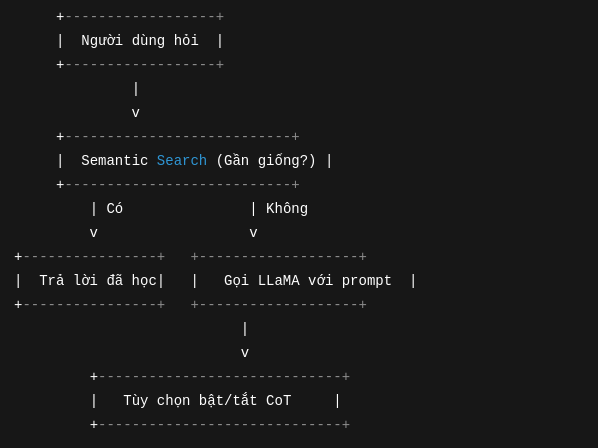

## Chuyển dữ liệu sang Prompt

In [ ]:
import json, os
from glob import glob
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from datasets import load_dataset, concatenate_datasets
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from trl import SFTTrainer


In [ ]:
DATA_DIR = "/content/drive/MyDrive/chatbot/data"

In [ ]:
def format_prompt_cot_step(user_input: str) -> str:
    return (
        f"User: {user_input}\n\n"
        "Assistant: Trước khi trả lời, tôi muốn dành một chút thời gian để lắng nghe và hiểu rõ tâm trạng của bạn.\n"
        "Hãy để tôi phân tích tình huống này với sự thấu cảm...\n"
        "Phân tích:\n"
        "Bước 1: Nhận diện cảm xúc chính.\n"
        "Bước 2: Tìm nguyên nhân có thể gây ra cảm xúc đó.\n"
        "Bước 3: Đề xuất phản hồi phù hợp.\n\n"
        "Phản hồi:"
    )


In [ ]:
# Thư mục chứa JSON messages gốc
INPUT_DIR = os.path.join(DATA_DIR, "parts")      # ví dụ: .../parts/part1.json, part2.json...
# Thư mục lưu JSON CoT
OUTPUT_DIR = os.path.join(DATA_DIR, "data_cot")
os.makedirs(OUTPUT_DIR, exist_ok=True)

for path in glob(f"{INPUT_DIR}/part*.json"):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    cot_data = []
    for conv in data:
        user_q = conv[0]["content"]
        bot_a  = conv[1]["content"]
        cot_data.append({
            "prompt": format_prompt_cot_step(user_q),
            "response": bot_a
        })
    out_path = os.path.join(OUTPUT_DIR, os.path.basename(path))
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(cot_data, f, ensure_ascii=False, indent=2)
    print(f"Converted → {out_path} ({len(cot_data)} examples)")

## ⚙️ 2) FINE‑TUNING với QLoRA


In [ ]:
# 4.1) Thiết lập model & tokenizer
MODEL_ID = "meta-llama/Meta-Llama-3-1B"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    load_in_4bit=True,
    device_map="auto",
    torch_dtype=torch.float16
)
model = prepare_model_for_kbit_training(model)

In [ ]:
# 4.2) Cấu hình LoRA
lora_config = LoraConfig(
    r=16, lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none", task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)


In [ ]:
# 4.3) Load & kết hợp dataset
cot_files = glob.glob(f"{OUTPUT_DIR}/part*.json")
datasets = [load_dataset("json", data_files=f, split="train") for f in cot_files]
dataset = concatenate_datasets(datasets)


In [ ]:
# 4.4) Tokenize & chuẩn bị cho SFTTrainer
def preprocess(examples):
    prompts = examples["prompt"]
    responses = examples["response"]
    inputs = [p + " " + r + tokenizer.eos_token for p, r in zip(prompts, responses)]
    tokens = tokenizer(inputs, truncation=True, max_length=512)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

dataset = dataset.map(preprocess, batched=True, remove_columns=["prompt", "response"])


In [ ]:
# 4.5) TrainingArguments
training_args = TrainingArguments(
    output_dir="checkpoints",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=2e-4,
    logging_steps=20,
    save_strategy="epoch",
    bf16=True,
)

In [ ]:
# 4.6) Khởi tạo SFTTrainer & train
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=lora_config,
    args=training_args,
    tokenizer=tokenizer
)

## 3) INFERENCE theo CoT


In [ ]:
MODEL_ID = "meta-llama/Meta-Llama-3-1B"
CHECKPOINT = "checkpoints/final"

In [ ]:
# 5.1) Load model + tokenizer
model = AutoModelForCausalLM.from_pretrained(
    "checkpoints/final",
    device_map="auto",
    torch_dtype=torch.float16
)

In [ ]:
def format_prompt_cot_step(user_input: str) -> str:
    return (
        f"User: {user_input}\n\n"
        "Assistant: Trước khi trả lời, tôi muốn dành một chút thời gian để lắng nghe và hiểu rõ tâm trạng của bạn.\n"
        "Hãy để tôi phân tích tình huống này với sự thấu cảm...\n"
        "Phân tích:\n"
        "Bước 1: Nhận diện cảm xúc chính.\n"
        "Bước 2: Tìm nguyên nhân có thể gây ra cảm xúc đó.\n"
        "Bước 3: Đề xuất phản hồi phù hợp.\n\n"
        "Phản hồi:"
    )

In [ ]:
# 2) Load model & tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    CHECKPOINT,
    device_map="auto",
    torch_dtype=torch.float16
)

In [ ]:
# 3) Sinh và parse output
def generate_cot(user_input: str, 
                 max_new_tokens: int = 150,
                 temperature: float = 0.7,
                 top_p: float = 0.9):
    prompt = format_prompt_cot_step(user_input)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_p=top_p,
        temperature=temperature,
        eos_token_id=tokenizer.eos_token_id
    )
    text = tokenizer.decode(out[0], skip_special_tokens=True)
    
    # 4) Tách thought và response
    # Giả sử output có dạng: "... Phân tích:\n<...>Phân hồi:<response>"
    thought_part = ""
    response_part = ""
    
    # Tách phần "Phân tích:" → "Phản hồi:"
    if "Phân tích:" in text and "Phản hồi:" in text:
        before, after = text.split("Phân tích:", 1)
        thought_raw, response_raw = after.split("Phản hồi:", 1)
        thought_part = thought_raw.strip()
        response_part = response_raw.strip()
    else:
        # fallback: coi toàn bộ là response
        response_part = text.strip()
    
    return {"thought": thought_part, "response": response_part}


In [ ]:
# Demo
if __name__ == "__main__":
    q = "Tôi thấy áp lực công việc quá mức và không biết chia sẻ với ai."
    out = generate_cot(q)
    print("===== THOUGHT =====")
    print(out["thought"])
    print("\n===== RESPONSE =====")
    print(out["response"])